# Building a circuit : Introductions to  Operations, Circuit, CircuitDAG, DAG visualization, openQASM/qiskit visualization, and pre-built circuits

## Overview [Public API]

The circuit classes contain our quantum algorithms (that is, the time-ordered sequence of operations which we apply on specific qubits to get from our input states to our target states).

They can, in principle, be represented in multiple different ways. Currently, our code base supports:
1. Directed-acyclic graph (DAG) circuit representation, for simulation
2. openQASM representation, for saving data, conversion to IBM's qiskit platform (note: this is only a visual compatibility at this point--more work is likely required to be able to simulate our circuits in qiskit).

## Photonic Circuits [Public API]

Our discrete photonic quantum circuits have 3 types of registers:
1. **Classical registers:** these registers store classical information like measurement results and can be used to control the application of gates on qubits. Typically, only one classical register is needed
2. **Photonic quantum registers:** these qubit registers are the qubits used in the construction of our target quantum state.
3. **Emitter quantum registers:** these registers are solid state qubits, which can generate photons (while this is not enforced by the circuit class, the emitters in fact generate the photon).

All the registers are zero-indexed. At this stage in the implementation, we only consider single-qubit registers.

## Operations

**[Public API]**

We support a set of operations which can be sequentially applied to form a quantum circuit. Operations are defined by the following:

1. **Operation type:** this is the class of the Operation object, and tells us what type of gate the Operation applies (e.g. CNOT, Hadamard)
2. **Their operation registers:** The operation registers defines the qubit/classical bit used by the operation. This must specify both the type of the register (classical, photonic quantum, emitter quantum), and its index.

In [1]:
""" Operation Examples """
import src.ops as ops

# Single Qubit Examples
# Hadamard on emitter 0
h = ops.Hadamard(register=0, reg_type='e')
# Pauli X gate on photon 1
paulix = ops.SigmaX(register=1, reg_type='p')


# Controlled Pair Example
# CNOT controlled by emitter 0, targeting photon 1
cnot = ops.CNOT(control=0, control_type='e', target=1, target_type='p')


# CLassically controlled pair example
# Classical CNOT, where emitter 2 is measured, saved to classical register 0, 
# and conditionally applied to photon 1
ccnot = ops.ClassicalCNOT(control=2, control_type='e', target=1, target_type='p', c_register=0)

# Classically controlled CNOT + measured qubit reset
# Emitter 0 is measured, saved to classical reg 0, conditional gate on photon 0
ccnot_reset = ops.MeasurementCNOTandReset(control=0, control_type='e',
                                          target=0, target_type='p',
                                          c_register=0)

In certain conditions, it may be useful to define a single operation object which applies multiple gates sequentially.

**NOTE:** this feature is only supported for single-qubit operations at the moment

In [2]:
""" Operation Wrapper Example """

HP_gate = ops.OneQubitGateWrapper([ops.Hadamard, ops.Phase], register=0, reg_type='p')

# NOTE: this applies first a phase gate, then a Hadamard gate on the register (following usual convention)

Optionally, a noise model can be proposed for each `Operation` (by default, the noise model is `NoNoise`).

In [3]:
import src.noise.noise_models as nm
h_with_noise = ops.CNOT(
    control=0,
    control_type='e',
    target=0,
    target_type='p',
    noise = nm.PauliError("X")
)

### Operation Base Classes/Inheritance [Implementer Info]

Because we want to be able to support different state representations with few changes to the API, these operation objects **do not encode how we apply the operation to the state**. That is, there is no code in these Operation objects that tells us how they modify states (this is handled in the compilers).

Then, there is a lot of similarities between the implementation of these different operation objects. To avoid rewriting the code repeatedly (bad practice, since it means each change must be made in multiple places!), we use **base classes** from which specific Operation objects (e.g. the Hadamard and CNOT viewed above) inherit code.

#### OperationBase

All Operation classes **inherit** from `OperationBase`.

**Python note:** A child class (e.g. `Hadamard`) may inherit from a parent class (e.g. `OperationBase`). This means that you can call functions on a child which ARE NOT EXPLICITLY defined in the child, if they are explicitly defined in the parent--if the child does not have its own version of the function, the code called will be the parent-code.

From an implementation point of view, this is also useful in the circuit implementation because the common superclass of the operations allows us to manipulate `Operation` objects in the same way regardless of their actual corresponding gate. 

Operation base has `q_registers`, `q_registers_type` and `c_registers` , in which it saves the information of which quantum/classical registers of the circuit it must act on. It also contains a noise model.

In [4]:
""" A look into OperationBase """

# Operation object which acts on quantum registers 0, 1 and classical register 0
base0 = ops.OperationBase(q_registers=(0, 1), 
                          q_registers_type=('e', 'p'),
                          c_registers=(0,))

# Careful, base0 may not be the same as base1! Order of register matters
base1 = ops.OperationBase(q_registers=(1, 0), 
                          q_registers_type=('e', 'p'),
                          c_registers=(1,))

# NOTE: the comma in c_registers=(0,) is necessary in python to make c_registers a TUPLE (iterable data) instead of an int

#### InputOutputOperationBase, SingleQubitOperationBase, InputOutputOperationBase, ControlledPairOperationBase, ClassicalControlledPairOperationBase

All the above inherit from `OperationBase`: like `OperationBase`, they exist such that we can recycle code between similar operations (for example, all single-qubit unitary gates acting on qubits need similar info stored)

See `ops.py` for their precise implementations

#### The "real" operations

Finally, we get to the "real" operations which we want in our circuit (note that you can PLACE the base classes in the circuit object--mostly for testing purposes--but that the compiler will raise an error if you try to compile the base classes)

These include:

**InputOutputOperationBase** types: Input, Output (these are simply placeholder Operations to signal the beginning/end of the circuit)

**SingleQubitOperationBase** types: Hadamard, SigmaX,SigmaY, SigmaZ

**ControlledPairOperationBase** types: CNOT, CPHASE

**ClassicalControlledPairOperationBase** types: classical CNOT/CPHASE, MeasurementCNOTandReset (same as classical CNOT, with the measured qubit being reset to |0>)

**OperationBase** type (though we may want another base class later for this, if we implement more): MeasurementZ


## Circuit Class [Public API]

The circuit class is built to remember with `Operation`-type objects to apply in each order. It also provides visualization and saving-to-string functionalities.

Like with `OperationBase`, we have a base class called `Circuit` (to allow future software expansions). Unlike `OperationBase`, we only have one circuit implementation at the moment, called `CircuitDAG`.

`CircuitDAG` represents a circuit via a directed acyclic graph (DAG).

#### What is the DAG representation?

The circuit DAG representation is used by other simulator softwares such as qiskit (IBM). Each NODE of the graph corresponds to an operation. Each EDGE of the graph corresponds to a qubit.

The graph is directed because the operations have an order. The direction of the edges follows the direction of time.

The graph is acyclic, because each a loop would indicate that a certain operation A occurs both before and after a certain operation B.

Example:

![DAG example](../img/circuit_dag_explanation.PNG "DAG Circuit Example")

#### [Implementer's note]

The underlying representation of our circuit uses the `networkx` graph package `MultiDiGraph` class, such that we can represent multiple edges between the same nodes (for example, two consecutive CNOT gates on the same pair qubits would be represented as two CNOT nodes, connected by two edges--one for each qubit)

#### [End of Implementer's note]

In [5]:
""" Create and validate a circuit """
import src.ops as ops
from src.circuit import CircuitDAG

# NOTE: all the operations below are callable on any circuit object
# but... we will only have CircuitDAG implemented for the foreseeable future

# Create a circuit with 2 quantum registers and 1 classical registers
# If you don't specify n_quantum, n_classical, an empty circuit (no registers) is created by default
circuit = CircuitDAG(n_emitter=1, n_photon=1, n_classical=1)

circuit.add(ops.Hadamard(register=0, reg_type='e'))
circuit.add(ops.CNOT(control=0, control_type='e', target=0, target_type='p'))

circuit.validate()  # will raise an AssertionError if not valid!

In [6]:
""" Example where the circuit is invalid """
import src.ops as ops
from src.circuit import CircuitDAG

invalid_circuit = CircuitDAG(n_emitter=1, n_photon=0, n_classical=0)

# Adding this operation creates a self-loop in the graph, since the control and target are the same. This is not valid!
invalid_circuit.add(ops.CNOT(control=0, control_type='e', target=0, target_type='e'))

try:
    invalid_circuit.validate()  # will raise an AssertionError if not valid!
except AssertionError:
    print(f'Validate function raised an AssertionError!')

Validate function raised an AssertionError!


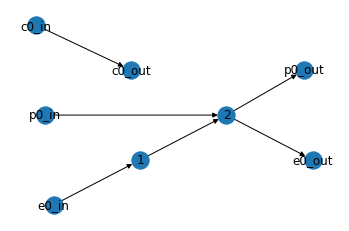

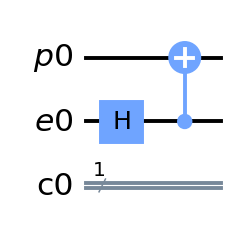

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [7]:
""" Visualization """

# Now, let's visualize the first circuit we made

circuit.draw_dag()  # DAG visualization--this shows the internal circuit representation
circuit.draw_circuit()  # this shows the circuit diagram

We see that node 1 seems to be the Hadamard, and node 2 is the CNOT.

In general, the operations are numbered. If you add an Operation on registers of size > 1, each pair of qubits affected by the Operation get their own number. **For now, all registers are single-qubit registers**.

#### How to change the circuit size

The circuit size does not have to be initially defined. You can also add registers via an explicit function call, or add `Operation` objects to the circuit which add registers.

If you choose to add `Operation` objects to grow the circuit, however, make sure to add the register numbers contiguously (an error will be raised if you leave a gap in the photon numbering).

initial circuit
Emitter num: 0
Photon num: 0
Classical bit num: 0


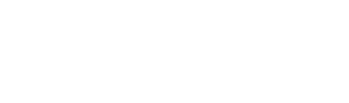


 circuit after operation
Emitter num: 1
Photon num: 1
Classical bit num: 0


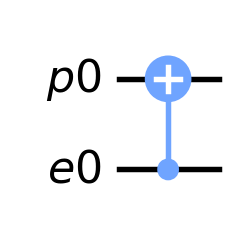

circuit after adding a classical and emitter register
Emitter num: 2
Photon num: 1
Classical bit num: 1


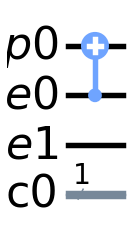


gap left in photon ordering, raises an error
ERROR
Register numbering must be continuous. Photonic qubit register 2 cannot be added. Next register that can be added is 1


In [8]:
""" Growing the circuit through operations """

def print_circuit_size(c):
    print(f'Emitter num: {c.n_emitters}')
    print(f'Photon num: {c.n_photons}')
    print(f'Classical bit num: {c.n_classical}')
    c.draw_circuit()

circuit = CircuitDAG()
print('initial circuit')
print_circuit_size(circuit)

circuit.add(ops.CNOT(control=0, control_type='e', target=0, target_type='p'))
print('\n circuit after operation')
print_circuit_size(circuit)

circuit.add_classical_register()
circuit.add_emitter_register()
print('circuit after adding a classical and emitter register')
print_circuit_size(circuit)

print('\ngap left in photon ordering, raises an error')
try:
    circuit.add(ops.Hadamard(register=2, reg_type='p'))
except ValueError as e:
    print('ERROR')
    print(e)

#### Advanced circuit building (CircuitDAG specific)

In certain solver applications, it is useful to be able to swap, insert, and remove operations from the circuit. 

Initial circuit


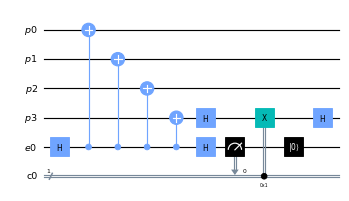

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [9]:
""" Consider """

import benchmarks.circuits as circ 

# This initial circuit is provided by the code base
circuit, _ = circ.ghz4_state_circuit()

print("Initial circuit")
circuit.draw_circuit()

Basic add: adds to the end of the circuit


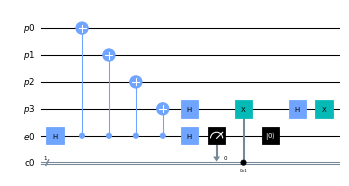

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [10]:
print("Basic add: adds to the end of the circuit")
circuit.add(ops.SigmaX(register=3, reg_type='p'))
circuit.draw_circuit()

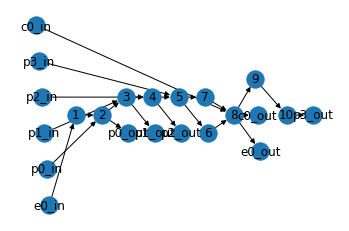

Insert at: insert operations on specific DAG edges (e.g. 3 and 4)


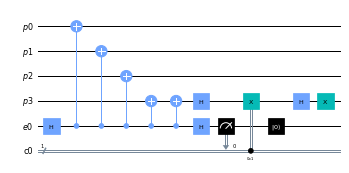

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [11]:
circuit.draw_dag()

"""
Say we want to add a second CNOT across e0, p3 (after the first one)
The DAG edge we add on is between nodes 5 and 7 (on "e0"), 5 and 6 (on "p3")

Note that this is not obvious, but the solvers typically track this information
"""

print("Insert at: insert operations on specific DAG edges (e.g. 3 and 4)")
circuit.insert_at(ops.CNOT(control=0, control_type='e',
                           target=3, target_type='p'),
                  [(5, 6, 'p3'), (5, 7, 'e0')])
circuit.draw_circuit()

Remove op: Remove a given operation


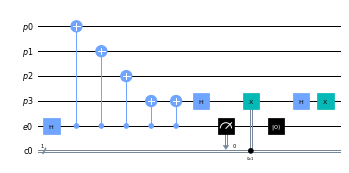

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [12]:
"""
Remove the hadamard on e0
"""

print("Remove op: Remove a given operation")
circuit.remove_op(7)
circuit.draw_circuit()

Our solvers can also swap components, but there is not explicit circuit class function for this.

#### Get a sequence of operations

In our software, the circuit is responsible for providing the compiler with a sequence of operations to compile. This sequence is built from the nodes of the graph provided in "topological" order:

In [13]:
op_seq = circuit.sequence()
print("operation objects (sequence):")
print(op_seq)

operation objects (sequence):
[<src.ops.Input object at 0x0000029470CB18E0>, <src.ops.Input object at 0x0000029470CB1160>, <src.ops.Input object at 0x00000294710122E0>, <src.ops.Input object at 0x0000029470CC8310>, <src.ops.Input object at 0x0000029470CC8400>, <src.ops.Input object at 0x0000029470CC8520>, <src.ops.Hadamard object at 0x0000029470CB1820>, <src.ops.CNOT object at 0x0000029470CB1610>, <src.ops.Output object at 0x0000029471012E50>, <src.ops.CNOT object at 0x0000029470CC8700>, <src.ops.Output object at 0x0000029470CC8130>, <src.ops.CNOT object at 0x0000029470CC87F0>, <src.ops.Output object at 0x0000029470CC8430>, <src.ops.CNOT object at 0x0000029470CC8760>, <src.ops.CNOT object at 0x000002946A43F970>, <src.ops.Hadamard object at 0x0000029470CC86D0>, <src.ops.MeasurementCNOTandReset object at 0x0000029470CC8640>, <src.ops.Output object at 0x000002947101A0D0>, <src.ops.Output object at 0x0000029470CC8610>, <src.ops.Hadamard object at 0x0000029470CC8220>, <src.ops.SigmaX object

### Saving and visualization

We want to be able to save circuits to the disk; saving the circuit python object is a) cumbersome and b) risky (we may lose the ability to open a store python object if we change the circuit implementation).

OpenQASM is a standard way of describing a quantum circuit, so we opt to save our circuit in the openQASM format (represented as a string in code). We can also load in openQASM files (defined as in our code⁠—this may not work for arbitrary openQASM circuits) to create a new circuit object.

**NOTE 1:** our current openQASM construction is intended primarily for:

a) Visualization purposes and

b) Saving purposes

The actual gate definitions in the file should be double-checked, if we want to simulate our circuits in another platform via openQASM.

**NOTE 2:** openQASM does not distinguish between photonic qubits and emitter qubits (this distinction is particular to photonic quantum computing applications). In our openQASM scripts, we distinguish photonic and emitter qubits by the naming convention of our registers.

In [14]:
""" Get openQASM string from circuit """

print("openQASM representation of the circuit:")
print(circuit.to_openqasm())

openQASM representation of the circuit:
OPENQASM 2.0;

gate h a { U(pi/2, 0, pi) a; }

gate x a { U(pi, 0, pi) a; }
qreg p0[1];
qreg p1[1];
qreg p2[1];
qreg p3[1];
qreg e0[1];
creg c0[1];

h e0[0];
CX e0[0], p0[0];
CX e0[0], p1[0];
CX e0[0], p2[0];
CX e0[0], p3[0];
CX e0[0], p3[0];
h p3[0];
barrier p0, p1, p2, p3, e0;
measure e0[0] -> c0[0]; 
if (c0==1) x p3[0]; 
barrier e0, p3; 
reset e0[0];
barrier p0, p1, p2, p3, e0;
h p3[0];
x p3[0];


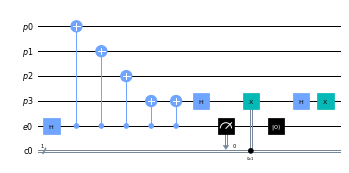

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [15]:
""" Define a new circuit with an openQASM string """

openqasm_str = circuit.to_openqasm()

circuit_copy = CircuitDAG.from_openqasm(openqasm_str)
circuit_copy.draw_circuit()